# Sentinel-2A Data Download & Preprocessing
This notebook shows you how to use GeoPandas, Google Earth Engine, and Rasterio to:

1. Fetch Kenya administrative boundaries from a provided Geojson file 
2. Generate an Sentinel-2A RGB for one county


## Installation

In [ ]:
!pip -q install geopandas
!pip -q install geojson
!pip -q install --upgrade folium
!pip -q install geemap
!pip -q install rasterio
!pip -q install tqdm


     |████████████████████████████████| 1.0MB 4.3MB/s 
     |████████████████████████████████| 6.6MB 41.9MB/s 
     |████████████████████████████████| 15.4MB 185kB/s 
     |████████████████████████████████| 102kB 4.1MB/s 
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.12.1 which is incompatible.
     |████████████████████████████████| 471kB 4.2MB/s 
     |████████████████████████████████| 143kB 23.0MB/s 
     |████████████████████████████████| 225kB 37.5MB/s 
     |████████████████████████████████| 3.3MB 29.6MB/s 
     |████████████████████████████████| 81kB 9.6MB/s 
     |████████████████████████████████| 1.6MB 50.8MB/s 
     |████████████████████████████████| 1.2MB 46.3MB/s 
     |████████████████████████████████| 1.3MB 38.0MB/s 
     |████████████████████████████████| 102kB 10.0MB/s 
     |████████████████████████████████| 81kB 9.2MB/s 
     |████████████████████████████████| 122kB 39.3MB/s 
     |████████████████████████████████| 122kB 47.4MB/s 
 

## Imports & Setup

In [ ]:

%matplotlib inline
import matplotlib.pyplot as plt
from tqdm import tqdm
import json
import geojson
import requests

import rasterio as rio
from rasterio.plot import show
import rasterio.mask
import geopandas as gpd
import numpy as np


from rasterio import windows
from shapely.geometry import box
import pandas as pd

import ee
import geemap
import geemap.eefolium as emap

## Mount Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


### Authenticate Google Earth Engine

In [ ]:
ee.Authenticate()
ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://accounts.google.com/o/oauth2/auth?client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code&code_challenge=MT_BefojiPXvos_dsHepUjevUlqzRwjW5ntkwiXsz8w&code_challenge_method=S256

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/1AX4XfWiW2zB18vvzr8X0pIvPdiOlJGipkMaTOtoKky5UjMTAk8xPNugmlX8

Successfully saved authorization token.


## Fetch Kenya from google drive...hopefully you had earlier saved it

In [ ]:
kenya_Counties = './drive/My Drive/side gig/Omdena_learning_presentation/Kenyan_counties.geojson' #Change this to your geojson file destination path


## Visualize Counties in Kenya

In [ ]:

##load the geojson and find the column containing county names
counties=gpd.read_file(kenya_Counties)
counties.head(3)

,OBJECTID,AREA,PERIMETER,COUNTY3_,COUNTY3_ID,COUNTY,Shape_Leng,Shape_Area,geometry
0,1,5.677,15.047,2.0,1.0,Turkana,15.046838,5.676985,"POLYGON ((35.79593 5.34449, 35.79659 5.34468, ..."
1,2,6.177,11.974,3.0,2.0,Marsabit,11.974165,6.176831,"POLYGON ((36.05061 4.45622, 36.23184 4.45124, ..."
2,3,2.117,7.355,4.0,3.0,Mandera,7.355154,2.117196,"POLYGON ((41.62133 3.97673, 41.62272 3.97860, ..."


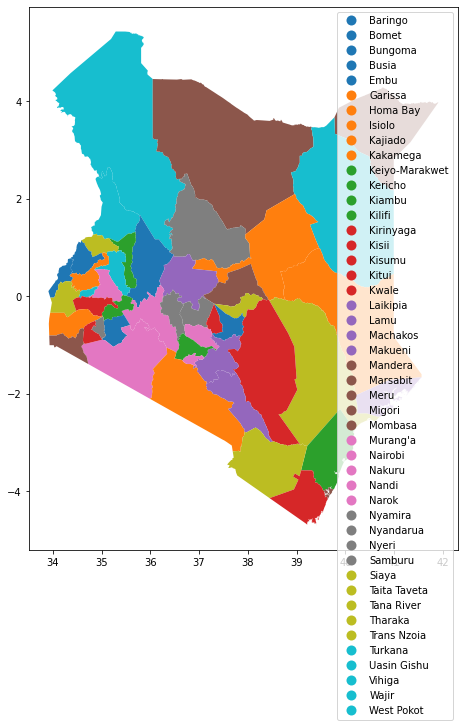

In [ ]:
#Visualize the high risk areas
fig, ax=plt.subplots(1,figsize=(10,10))
counties.plot('COUNTY',legend=True,ax=ax)
plt.show()


## Generate Sentinel-2A Composite using Google Earth Engine

**Note**: You'll need to sign up for access to Google Earth Engine at https://code.earthengine.google.com/. 

### Generate Sentinel-2A Image for Kenya.

In [ ]:
def generate_image(
    region, 
    centroid, 
    product='COPERNICUS/S2', 
    min_date='2020-01-01',
    max_date='2020-12-31',
    bands='RGBNIR',
    range_min=0,
    range_max=2000,
    cloud_pct=10,
    debug=True
):

    """Generates Sentinel-2 image using Google Earth Engine."""
             
    image = ee.ImageCollection(product)\
        .filterBounds(region)\
        .filterDate(str(min_date), str(max_date))\
        .filter(ee.Filter.lt("CLOUDY_PIXEL_PERCENTAGE", cloud_pct))\
        .mosaic()



    if bands == 'RGBNIR':
      image = image.select('B4','B3','B2','B8')

    if bands =="RGB_NIR_SWIR1":
      image=image.select('B4','B3','B2','B8','B11','B12')
               
    elif bands == 'RGB':
      image = image.select('B4','B3','B2')
      

    return image.clip(region) #return Image

In [ ]:
# Get the polygon for county Tharaka
county_name = 'Nairobi'
county = counties[counties.COUNTY == county_name]

# Generate centroid and polygon
centroid = county.centroid.iloc[0].coords[0]
minx=county.bounds['minx'].values[0]
miny=county.bounds['miny'].values[0]
maxx=county.bounds['maxx'].values[0]
maxy=county.bounds['maxy'].values[0]
geometry = ee.Geometry.Rectangle([minx,miny,maxx,maxy])

range_min=0
range_max=2000

image = generate_image(
    geometry, 
    centroid, 
    min_date='2020-01-01',
    max_date='2020-12-31', 
    range_min=range_min,
    range_max=range_max,
    cloud_pct=1, 
    product='COPERNICUS/S2',
    bands="RGB_NIR_SWIR1"
)
##visualize True colour composites
visualizeImage = image.visualize(bands=['B4', 'B3', 'B2'], min=range_min, max=range_max)

##visualize colour composites
    #helps to differentiate clouds and cloud shadows,built up areas and Vegetation
visualizeImage843 = image.visualize(bands=['B8', 'B4', 'B3'], min=range_min, max=range_max)
    #to bring out urban areas and roads                                                                                          
visualizeImage12_11_4 = image.visualize(bands=['B12', 'B11', 'B4'], min=range_min, max=range_max)

##Calculate NDVI normalized difference Vegetation Index
nir=image.select("B8")
red=image.select("B4")
ndvi=nir.subtract(red).divide(nir.add(red)).rename("NDVI")
visParamsNdvi={min:-1, max:1,"palette":["grey","white","green"]}

##Calculate NDBI- Normalized difference Building Index
swir1=image.select("B11")
ndbi=swir1.subtract(nir).divide(swir1.add(nir)).rename("NDBI")
visParamsNdbi={min:-1, max:1,"palette":["grey","white","yellow","red"]}


# Visualize map
Map = emap.Map(center=[centroid[1], centroid[0]], zoom=10)
Map.addLayer(visualizeImage, {}, 'Sentinel2')

Map.addLayer(visualizeImage843, {}, 'Colour_composite843')
Map.addLayer(visualizeImage12_11_4, {}, 'Colour_composite12_11_4')

Map.addLayer(ndvi,visParamsNdvi,"NDVI_Image")
Map.addLayer(ndbi,visParamsNdbi,"Urban_Image")

Map.addLayer(geometry, {}, 'Geometry')
Map.addLayerControl()
Map

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  


### Export Image to Local Gdrive


Note: This may take some time, depending on the size of the images.

In [ ]:
def export_image(image, filename, region, folder, debug=True):
    """Export Image to Google Drive."""

    if debug: print('Exporting to {}.tif ...'.format(filename))
        
    task = ee.batch.Export.image.toDrive(
      image=image,
      driveFolder=folder,
      scale=10,
      region=region,
      description=filename,
      fileFormat='GeoTIFF',
      crs='EPSG:4326',
      maxPixels=900000000
    )
    task.start()
    
    return task

In [ ]:
folder = 'NAIROBI_Imagery' #to create such a folder in your drive
task=export_image(image, county_name, geometry, folder)


Exporting to Nairobi.tif ...


You can run `task.status()` to see the state of the task. After a while, the status should change from "READY" to "RUNNING" to "COMPLETE".

Alternatively, you can go to https://code.earthengine.google.com/ to check the status of the task.

In [ ]:
task.status()